<a href="https://colab.research.google.com/github/unique-subedi/gene-expression/blob/main/Ahn_gene_expression_master.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import datetime
import time
import math
import numpy as np
from numpy import linalg as LA
import scipy 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import urllib.request

In [2]:
!pip install pyreadr
import pyreadr
urllib.request.urlretrieve("https://raw.githubusercontent.com/unique-subedi/gene-expression/main/data/brain.rda", "brain.rda")
brain = pyreadr.read_r("brain.rda")

expression = pd.DataFrame(brain["expression"])
genes = pd.DataFrame(brain["genes"])
samples = pd.DataFrame(brain["samples"])

# Select bacterial controls
genes.at["AFFX-BioDn-3_at", 'chrom'] = float("Nan")
genes_control = genes[['AFFX' in s for s in genes.index]]
genes_control = genes_control[['HUM' not in s for s in genes_control.index]]
genes_control = genes_control[['hum' not in s for s in genes_control.index]]
genes_bac_index = genes_control[genes_control.chrom.isnull() & genes_control.sym.isnull()].index

# Microarray level Normalization: Detected microarray-wise effects for both michigan and irvine
# We ideally want very similar distribution(mean, std) for each microarray. 
# This does not remove lab effects/heterogeneity across labs
mean_bac_exp = expression[genes_bac_index].mean(axis=1)
std_bac_exp = expression[genes_bac_index].std(axis=1)
expression_norm =  (expression - mean_bac_exp.values[:, None]).divide(std_bac_exp, axis=0)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 363 kB 13.7 MB/s 


# Data Preparation

`michigan` dataset contains the measurements, done at University of Michigan lab, of anterior cortex and dorsolateral cortex for each patient. 

`michigan_diff` subtracts measurement of anterior cortex from the dorsolateral cortex for each patient.

In [3]:
# Michigan
michigan = expression_norm[(expression.index.str[5] == 'M') & (expression.index.str[3] != 'c') ]
michigan_diff = michigan.diff().iloc[1::2,:]
michigan_diff.index = "patient" + michigan_diff.index.str[:2]
#michigan_diff

# Davis
davis = expression_norm[(expression.index.str[5] == 'D') & (expression.index.str[3] != 'c') ]
davis = davis[~davis.index.str[1].isin(['1', '2', '5', '6', '7', '9'])]
davis_diff = davis.diff().iloc[1::2,:]
davis_diff.index = "patient" + davis_diff.index.str[:2]
#davis

# Irvine
irvine = expression_norm[(expression.index.str[5] == 'I') & (expression.index.str[3] != 'c') ]
irvine_diff = irvine.diff().iloc[1::2,:]
irvine_diff.index = "patient" + irvine_diff.index.str[:2]
#irvine_diff

In [ ]:
'''
plt.figure(figsize=(20, 8))
plt.grid()
sns.boxplot(data=michigan.T)

plt.figure(figsize=(20, 8))
plt.grid()
sns.boxplot(data=irvine.T)
'''

'\nplt.figure(figsize=(20, 8))\nplt.grid()\nsns.boxplot(data=michigan.T)\n\nplt.figure(figsize=(20, 8))\nplt.grid()\nsns.boxplot(data=irvine.T)\n'

Text(0.5, 0, 'Probe sets')

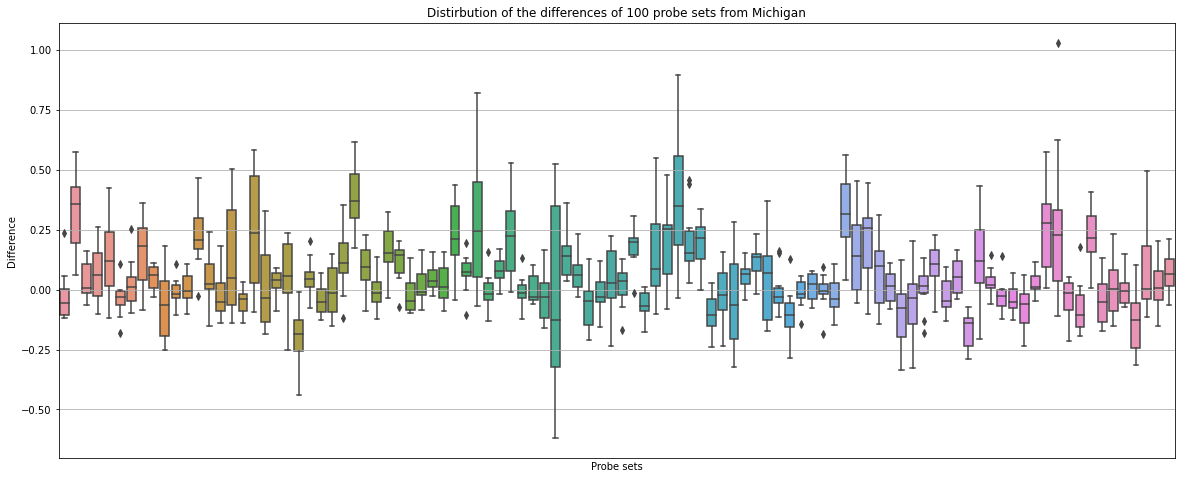

In [ ]:
# Plot human genes
plt.figure(figsize=(20, 8))
plt.grid()
sns.boxplot(data=michigan_diff.iloc[:, 200:300])
plt.title('Distirbution of the differences of 100 probe sets from Michigan')
plt.tick_params(labelbottom=False, bottom = False)
plt.ylabel('Difference')
plt.xlabel('Probe sets')


Text(0.5, 0, 'Probe sets')

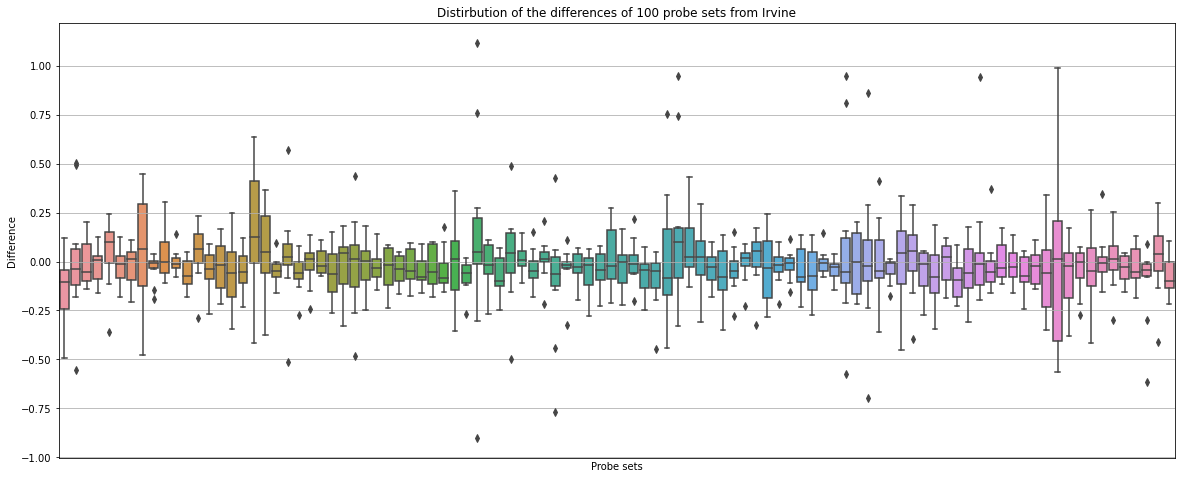

In [ ]:
plt.figure(figsize=(20, 8))
plt.grid()
sns.boxplot(data=irvine_diff.iloc[:, 200:300])
plt.title('Distirbution of the differences of 100 probe sets from Irvine')
plt.tick_params(labelbottom = False, bottom=False)
plt.ylabel('Difference')
plt.xlabel('Probe sets')

Text(0.5, 0, 'Probe sets')

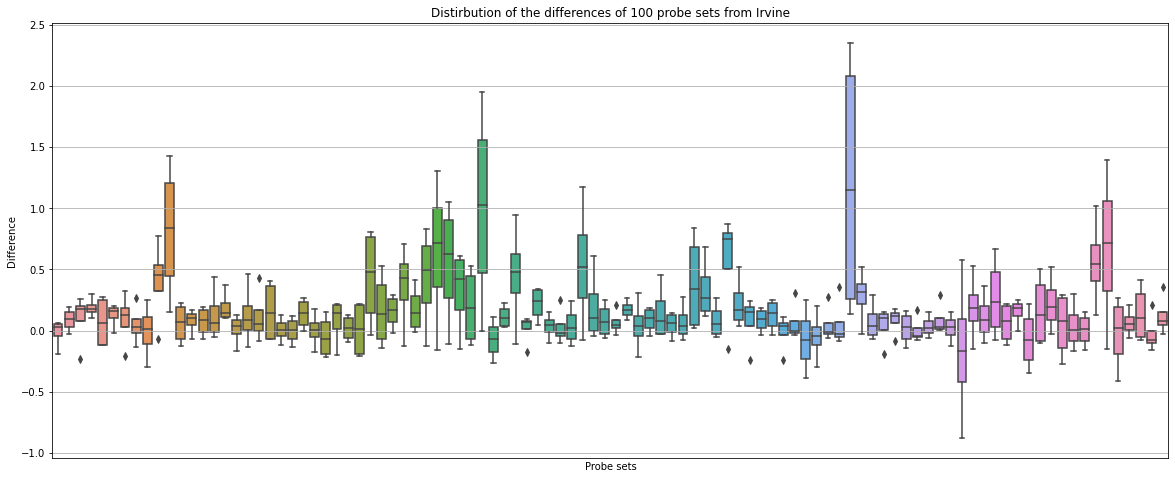

In [ ]:
plt.figure(figsize=(20, 8))
plt.grid()
sns.boxplot(data=davis_diff.iloc[:, 300:400])
plt.title('Distirbution of the differences of 100 probe sets from Irvine')
plt.tick_params(labelbottom = False, bottom=False)
plt.ylabel('Difference')
plt.xlabel('Probe sets')

In [ ]:
'''
m = michigan_diff.apply(np.mean)
i = irvine_diff.apply(np.mean)

means = pd.DataFrame({'M': m, 'I':i})
plt.figure(figsize=(20, 10))
plt.plot(means.M[300:600], label='Michigan')
plt.plot(means.I[300:600], label='Irvine')
plt.axhline(y=0, color='grey')
plt.title('Mean of the differences for each gene')
plt.legend()
'''

"\nm = michigan_diff.apply(np.mean)\ni = irvine_diff.apply(np.mean)\n\nmeans = pd.DataFrame({'M': m, 'I':i})\nplt.figure(figsize=(20, 10))\nplt.plot(means.M[300:600], label='Michigan')\nplt.plot(means.I[300:600], label='Irvine')\nplt.axhline(y=0, color='grey')\nplt.title('Mean of the differences for each gene')\nplt.legend()\n"

# Hypothesis testing 
Wilcoxon signed-rank test/paired t-test for each gene excluding controls
Tests whether the median of the difference is 0/mean of the difference is 0.  
Wilcoxon signed-rank test: A non-parametric alternative test to the paired t-test. 

## Multiple Hypotheses Testing on the actual data

In [4]:
from scipy.stats import wilcoxon
from scipy.stats import ttest_1samp
from statsmodels.stats.multitest import multipletests

def get_gene_pvalues(probe_set_pval):
  '''
  Outputs the p-values for each 'gene'.
  For each gene, there could be multiple corresponding probesets. We take the maximum value of the p-values for the gene p-value
  '''
  unique_genes = genes_u.sym.unique()

  # Match probeset to the gene
  gene_to_probe_set = {}
  for gene in unique_genes:
    gene_to_probe_set[gene] = genes_u.index[genes_u.sym == gene].tolist()
  
  # Get the gene_pvalues(highest p-value among all the probesets)
  gene_p_values = pd.Series()

  # Iterate over genes:
  for gene in unique_genes:
    gene_p = 0
    gene_probes = gene_to_probe_set[gene]
    # For each probe from a gene
    for probe in gene_probes:
      gene_p = max(gene_p, probe_set_pval[probe])

    gene_p_values[gene] = gene_p

  return gene_p_values


def testing(df, lab, mode):
  
  '''
  do Wilcoxon signed-rank test/paired t-test for each gene. 
  Make either Bonferroni or Benjamini-Hochberg correction when doing the multiple testing

  args:
  -----
  df: data frame without the controls
  lab: should be one of 'michigan', 'irvine', 'davis'
  mode: 'w' if Wilcoxon-signed-rank test, 't' if paired t-test
  '''

  if (mode=='w'):
    p_val = df.apply(wilcoxon).iloc[1,:]

    print(lab)
    print('Wilcoxon signed-rank test')

  else:
    p_val = pd.Series([ttest_1samp(df.iloc[:,i], 0)[1] for i in np.arange(df.shape[1])], index=df.columns)

    print(lab)
    print('Paired t-test')

  # Convert probeset p-values to gene p-values
  p_val = get_gene_pvalues(p_val)
  print(len(p_val))

  bonferr = pd.Series(multipletests(p_val, method='bonferroni', alpha=0.05)[1], index=p_val.index)
  bh = pd.Series(multipletests(p_val, method='fdr_bh', alpha=0.05)[1], index=p_val.index)

  # Storing
  pvals['_'.join([lab, mode])] = p_val
  rejected['_'.join([lab, mode])+'_b'] = bonferr 
  rejected['_'.join([lab, mode])+'_bh'] = bh  

  print('rejected H0(bonferroni):{}'.format(sum(bonferr)))
  print('rejected H0(BH):{} \n'.format(sum(bh)))
  plt.title('Histogram of the p-values')
  plt.hist(p_val, bins=np.arange(0, 1, 0.01), alpha=0.7, label=lab)
  plt.legend()

michigan
Wilcoxon signed-rank test


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


8783
rejected H0(bonferroni):8783.0
rejected H0(BH):3436.966328168272 

irvine
Wilcoxon signed-rank test
8783
rejected H0(bonferroni):8783.0
rejected H0(BH):7781.363874035655 



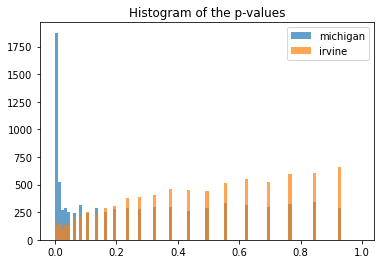

In [5]:
# `pvals` stores the pvalues, `rejected` stores the rejected H0 from the multiple hypothesis testing
pvals = {}
rejected = {}

# Genes that should be used
genes_u = genes[~pd.isna(genes.sym)]
genes_u = genes_u[['AFFX' not in s for s in genes_u.index]]
genes_u

# Remove controls, and select genes with symbols
michigan_diff = michigan_diff[genes_u.index]
irvine_diff = irvine_diff[genes_u.index]

testing(michigan_diff, 'michigan', 'w')
testing(irvine_diff, 'irvine', 'w')
#testing(davis_diff, 'davis', 'w')

michigan
Paired t-test


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


8783
rejected H0(bonferroni):8571.128152044545
rejected H0(BH):3117.4684668275345 

irvine
Paired t-test
8783
rejected H0(bonferroni):8782.346500063266
rejected H0(BH):7633.972626568166 



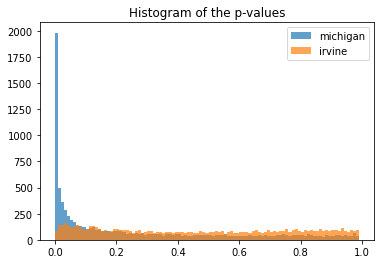

In [6]:
testing(michigan_diff, 'michigan', 't')
testing(irvine_diff, 'irvine', 't')
#testing(davis_diff, 'davis', 't')

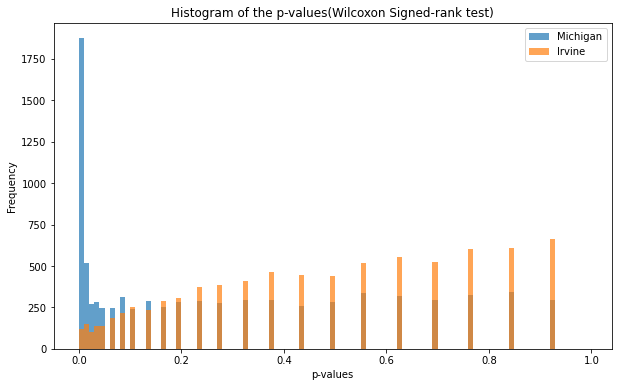

In [ ]:
plt.figure(figsize=(10, 6))
plt.title('Histogram of the p-values(Wilcoxon Signed-rank test)')
plt.hist(pvals['michigan_w'], bins=np.arange(0, 1, 0.01), alpha=0.7, label='Michigan')
plt.hist(pvals['irvine_w'], bins=np.arange(0, 1, 0.01), alpha=0.7, label='Irvine')
plt.xlabel('p-values')
plt.ylabel('Frequency')
plt.legend()

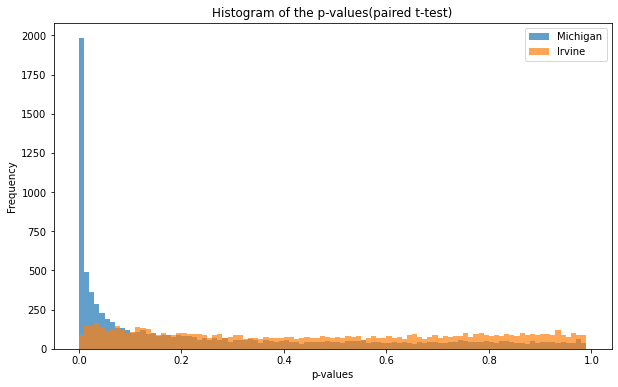

In [ ]:
plt.figure(figsize=(10, 6))
plt.title('Histogram of the p-values(paired t-test)')
plt.hist(pvals['michigan_t'], bins=np.arange(0, 1, 0.01), alpha=0.7, label='Michigan')
plt.hist(pvals['irvine_t'], bins=np.arange(0, 1, 0.01), alpha=0.7, label='Irvine')
plt.xlabel('p-values')
plt.ylabel('Frequency')
plt.legend()

# Gene Investigation

In [ ]:
pd.options.display.float_format = '{:.2e}'.format
top20_m = pvals['michigan_t'].sort_values().head(20)
top20_m.name='p-value'
top20_m

BTG2      3.28e-08
PPIH      4.45e-08
GALT      4.71e-08
GGCT      1.49e-07
CHI3L2    2.07e-07
MYRIP     2.10e-07
VASH1     2.55e-07
UROD      2.60e-07
GIPC1     4.96e-07
ZNF638    5.05e-07
ZBTB5     5.75e-07
UBR4      5.84e-07
HADHB     6.11e-07
KLC1      6.24e-07
RGP1      6.38e-07
NDUFS8    7.56e-07
SUMO3     7.68e-07
RASGRP1   1.08e-06
VCL       1.10e-06
FAM32A    1.13e-06
Name: p-value, dtype: float64

Find common genes between wilcoxon and paired t-test

In [7]:
pd.options.display.float_format = '{:.2e}'.format
# x, y: corrected p-values for the rejected genes
x = rejected['michigan_w_bh']
x = x[x<0.05].sort_values()
x = x.iloc[:100]

y = rejected['michigan_t_bh']
y = y[y<0.05].sort_values()
y = y.iloc[:100]

x.reset_index().merge(y.reset_index(), on='index')
#W = x.reset_index().merge(y.reset_index(), on='index').sort_values('0_x').head(50)
#P = x.reset_index().merge(y.reset_index(), on='index').sort_values('0_y').head(50)
#W.merge(P, on='index')


,index,0_x,0_y
0,VASH1,1.90e-02,2.86e-04
1,F8,1.90e-02,4.49e-04
2,FAM32A,1.90e-02,4.49e-04
3,DLG4,1.90e-02,5.02e-04
4,UGDH,1.90e-02,5.81e-04
5,EPRS,1.90e-02,9.75e-04
6,NXF1,1.90e-02,9.75e-04
7,AMH,1.90e-02,4.49e-04


In [8]:
# Do the procedure on the uncorrected p-values
x = rejected['michigan_w_bh']
x = x[x<0.05].sort_values()


y = rejected['michigan_t_bh']
y = y[y<0.05].sort_values()


x1 = pvals['michigan_t']
x1 = x1[x.index]
x1 = x1.iloc[:50]

y1 = pvals['michigan_w']
y1 = y1[y.index]
y1 = y1.iloc[:50]

#X = x1.reset_index().merge(y1.reset_index(), on='index').sort_values('p.val_x').head(50)
#Y = x1.reset_index().merge(y1.reset_index(), on='index').sort_values('p.val_y').head(50)
#X.merge(Y, on='index')
x1.reset_index().merge(y1.reset_index(), on='index')


,index,0_x,0_y
0,VASH1,2.55e-07,1.95e-03
1,F8,1.50e-06,1.95e-03
2,FAM32A,1.13e-06,1.95e-03
3,DLG4,2.35e-06,1.95e-03


Gene selection:  
1) select top 300 genes from each michigan and irvine lab.   
2) select the genes that overlap

In [9]:
pd.options.display.float_format = '{:.1e}'.format
# Gene selection from michigan and irvine
m = pvals['michigan_t']
m = m[m<0.05].sort_values()
m = m.iloc[:300]

i = pvals['irvine_t']
i = i[i<0.05].sort_values()
i = i.iloc[:300]

m.reset_index().merge(i.reset_index(), on='index').sort_values('0_x')

,index,0_x,0_y
0,RAB36,9.0e-06,2.0e-02
1,ZNF862,9.5e-06,1.5e-02
2,CHD1,1.5e-05,1.8e-02
3,GABRE,3.1e-05,2.5e-02
4,LOC283079,5.3e-05,1.4e-02
5,INSM1,5.5e-05,1.4e-02
6,LRP6,6.2e-05,1.7e-02
7,ERLIN1,7.0e-05,1.8e-02
